#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6314831026590117290
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15338858295615808338
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [12]:
import smogn

In [13]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'balance')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme', k = 7)
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme', k = 3)

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 162.49it/s]


In [15]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1210, 16)
(2151, 16)
(2183, 16)


In [16]:
As_smogn = As_smogn.reset_index(drop = True)
Cd_smogn = Cd_smogn.reset_index(drop = True)
Ni_smogn = Ni_smogn.reset_index(drop = True)

#### Eliminate outlier and train / test split

In [17]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [18]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [19]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [20]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [21]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1051, 15)
(1913, 15)
(2117, 15)


StandardScaler

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [20]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\n\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [21]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [23]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(840, 15)
(1530, 15)
(1693, 15)


#### 10-Fold Crossvalidation

In [24]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [25]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [26]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [27]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 00:50:49,476] A new study created in memory with name: rf_parameter_opt
[I 2023-08-30 00:50:50,315] Trial 0 finished with value: 0.343814552269856 and parameters: {'n_estimators': 55, 'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 3}. Best is trial 0 with value: 0.343814552269856.
[I 2023-08-30 00:50:50,633] Trial 1 finished with value: 0.3555660916907847 and parameters: {'n_estimators': 16, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 20}. Best is trial 1 with value: 0.3555660916907847.
[I 2023-08-30 00:50:51,027] Trial 2 finished with value: 0.14845943976728423 and parameters: {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 18, 'min_samples_split': 15}. Best is trial 1 with value: 0.3555660916907847.
[I 2023-08-30 00:50:53,051] Trial 3 finished with value: 0.39416175166645384 and parameters: {'n_estimators': 98, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}. Best is trial 3 with value: 0.39416175166645384.
[I 2023-0

Best r2:  0.43874882203315035
Best trial: {'n_estimators': 90, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}


In [28]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 90, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}


In [30]:
study.best_trial.params["n_estimators"]

90

In [31]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=9,
                      n_estimators=90, random_state=42)

In [32]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [32]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [33]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.36555591685368455
Test RMSE:  0.7446765451865593


In [34]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.8057982509995433
Test R2:  0.26426728314684866


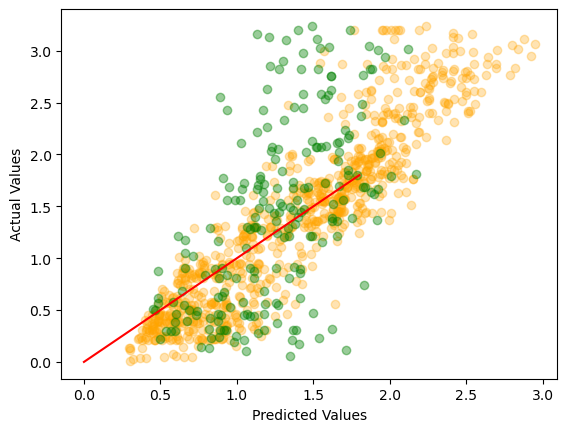

In [35]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

In [36]:
As_pred = pd.DataFrame(y_train_pred, columns = ['As_pred'])
As_pred_test = pd.DataFrame(y_test_pred, columns = ['As_pred'])

In [37]:
As_y_train = As_y_train.reset_index(drop = False)
As_y_test = As_y_test.reset_index(drop = False)

In [38]:
As_data = pd.concat([As_pred, As_y_train], axis = 1)
As_data_test = pd.concat([As_pred_test, As_y_test], axis = 1)

In [39]:
As_data.to_csv('RF_As_train_data.csv', sep = ',')
As_data_test.to_csv('RF_As_test_data.csv', sep = ',')

Cd

Optimization

In [40]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 01:06:35,535] A new study created in memory with name: rf_parameter_opt
[I 2023-08-30 01:06:36,848] Trial 0 finished with value: 0.5586520331099617 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 5}. Best is trial 0 with value: 0.5586520331099617.
[I 2023-08-30 01:06:37,172] Trial 1 finished with value: 0.32994017654362945 and parameters: {'n_estimators': 20, 'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 15}. Best is trial 0 with value: 0.5586520331099617.
[I 2023-08-30 01:06:40,253] Trial 2 finished with value: 0.5347899409511924 and parameters: {'n_estimators': 94, 'max_depth': 7, 'min_samples_leaf': 19, 'min_samples_split': 11}. Best is trial 0 with value: 0.5586520331099617.
[I 2023-08-30 01:06:42,558] Trial 3 finished with value: 0.5785223866901166 and parameters: {'n_estimators': 56, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 11}. Best is trial 3 with value: 0.5785223866901166.
[I 2023-

Best r2:  0.6146088207306227
Best trial: {'n_estimators': 91, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}


In [41]:
optuna.visualization.plot_parallel_coordinate(study)

In [42]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 91, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}


91

In [43]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=91, random_state=42)

In [44]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [45]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.0810000435442097
Test RMSE:  0.19675323488647553


In [46]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.8744641848587535
Test R2:  0.30544408275640866


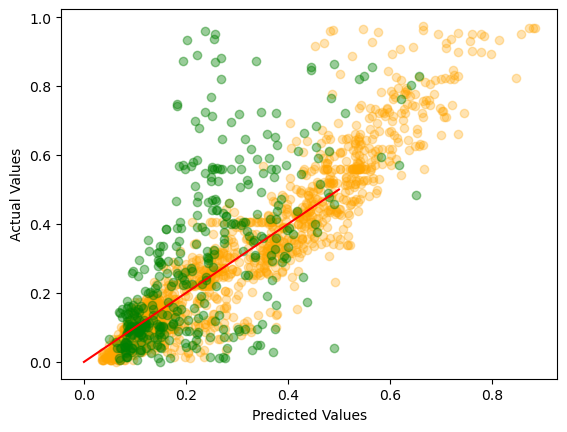

In [47]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

In [48]:
Cd_pred = pd.DataFrame(y_train_pred, columns = ['Cd_pred'])
Cd_pred_test = pd.DataFrame(y_test_pred, columns = ['Cd_pred'])

In [49]:
Cd_y_train = Cd_y_train.reset_index(drop = False)
Cd_y_test = Cd_y_test.reset_index(drop = False)

In [50]:
Cd_data = pd.concat([Cd_pred, Cd_y_train], axis = 1)
Cd_data_test = pd.concat([Cd_pred_test, Cd_y_test], axis = 1)

In [51]:
Cd_data.to_csv('RF_Cd_train_data.csv', sep = ',')
Cd_data_test.to_csv('RF_Cd_test_data.csv', sep = ',')

Ni

In [52]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 01:22:07,663] A new study created in memory with name: rf_parameter_opt
[I 2023-08-30 01:22:10,811] Trial 0 finished with value: 0.5503952961424547 and parameters: {'n_estimators': 83, 'max_depth': 9, 'min_samples_leaf': 16, 'min_samples_split': 16}. Best is trial 0 with value: 0.5503952961424547.
[I 2023-08-30 01:22:15,608] Trial 1 finished with value: 0.6454289156091864 and parameters: {'n_estimators': 95, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 9}. Best is trial 1 with value: 0.6454289156091864.
[I 2023-08-30 01:22:17,941] Trial 2 finished with value: 0.5967866258151286 and parameters: {'n_estimators': 53, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 8}. Best is trial 1 with value: 0.6454289156091864.
[I 2023-08-30 01:22:20,026] Trial 3 finished with value: 0.45054174352327114 and parameters: {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 9}. Best is trial 1 with value: 0.6454289156091864.
[I 2023-0

Best r2:  0.6873222500807167
Best trial: {'n_estimators': 84, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [53]:
optuna.visualization.plot_parallel_coordinate(study)

In [54]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 84, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


84

In [55]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, n_estimators=84, random_state=42)

In [56]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [57]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.33590467447700184
Test RMSE:  0.8909389853587627


In [58]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9237817538950975
Test R2:  0.43075956732075316


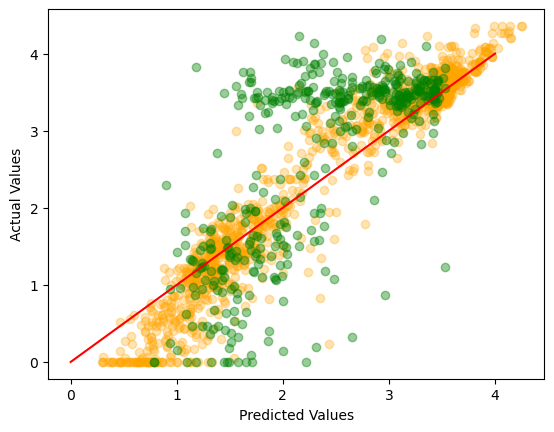

In [59]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

In [60]:
Ni_pred = pd.DataFrame(y_train_pred, columns = ['Ni_pred'])
Ni_pred_test = pd.DataFrame(y_test_pred, columns = ['Ni_pred'])

In [61]:
Ni_y_train = Ni_y_train.reset_index(drop = False)
Ni_y_test = Ni_y_test.reset_index(drop = False)

In [62]:
Ni_data = pd.concat([Ni_pred, Ni_y_train], axis = 1)
Ni_data_test = pd.concat([Ni_pred_test, Ni_y_test], axis = 1)

In [63]:
Ni_data.to_csv('RF_Ni_train_data.csv', sep = ',')
Ni_data_test.to_csv('RF_Ni_test_data.csv', sep = ',')